In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from env2 import env
#from DQNCore import DQNCore

In [2]:
import random
import numpy as np
import tensorflow as tf
from collections import deque

In [3]:
class DQNCore(object):
    def __init__(self, 
                 observation, 
                 num_actions, 
                 memory_size=1024, 
                 batch_size=32, 
                 gamma=.9, 
                 learning_rate=1e-3,
                 optimizer_epsilon = 1e-8,
                 l2_coefficient=1e-3,
                 max_gard_norm=50,
                 name='DNCore'):
        self.num_actions = num_actions
        self.memory_size = memory_size
        self.gamma = gamma # discount factor for excepted returns 
        self.batch_size = 32
        
        # placeholder for samples replay experience
        shape = [None] + list(observation.shape [1:])
        self.inputs = tf.placeholder(tf.float32, shape, 'inputs')
        self.targets = tf.placeholder(tf.float32, [None], 'targets') # y_j
        self.actions = tf.placeholder(tf.int32, [None], 'actions')
        self.rewards = tf.placeholder(tf.float32, [None], 'rewards')
        self.Q = self._build_QNetwork('Qeval', True) # state Q
        self.next_Q = self._build_QNetwork('next_eval',False) # next state Q
        
        # actions selection corresponding one hot matrix column
        one_hot = tf.one_hot(self.actions, self.num_actions, 1., 0.)
        Qmax = tf.reduce_sum(self.Q * one_hot, axis=1)
        cost = tf.reduce_mean(tf.squared_difference(Qmax, self.targets))
        # L2 正则化
        self._trainable_variables = tf.trainable_variables()
        _l2_regularizer = tf.add_n([tf.nn.l2_loss(v) for v in self._trainable_variables])        
        self._l2_regularizer = _l2_regularizer * l2_coefficient / len(self._trainable_variables)
        self._loss = self._l2_regularizer + cost
        
        # Set up optimizer with global norm clipping.
        trainable_variables = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self._loss, trainable_variables), max_gard_norm)
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])       
        optimizer = tf.train.RMSPropOptimizer(
            learning_rate=learning_rate, epsilon=optimizer_epsilon)
        self._train_op = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)  

        # update target network
        next_params = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, 
            scope='next_eval')
        Q_params = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, 
            scope='Qeval')
        self._update_target = [tf.assign(n,q) for n,q in zip(next_params, Q_params)]
        
        # session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())   
        self.sess.graph.finalize()
        
    def init(self):
        self.step_counter = 0       
        self.cache = deque(maxlen=self.memory_size) # replay experience

    def _build_QNetwork(self, name, trainable):
        with tf.variable_scope(name):
            # input layer
            network = tf.layers.conv2d(self.inputs, 32, [8,8], [4,4], 'same', 
                                       activation=tf.nn.relu, trainable=trainable, name='input_layer')
            # hidden layer
            network = tf.layers.conv2d(network, 64, [4,4], [2,2], 'same', 
                                       activation=tf.nn.relu, trainable=trainable, name='hidden_layer')
            # hidden layer 2nd
            network = tf.layers.conv2d(network, 64, [3,3], [1,1], 'same', 
                                       activation=tf.nn.relu, trainable=trainable, name='hidden_layer_2nd')
            # final layer
            network = tf.contrib.layers.flatten(network)
            network = tf.layers.dense(network, 512, tf.nn.relu, 
                                      trainable=trainable, name='final_layer')
            # output layer
            network = tf.layers.dense(network, self.num_actions, None, 
                                      trainable=trainable, name='output_layer')
            return network

    def update_nextQ_network(self): 
        # zip 长度不等时，取长度的最小的
        self.sess.run(self._update_target)

    def update_cache(self, state, action, reward, next_state, done):
        # update replay experience pool
        self.cache.append((state, action, reward, next_state, done))

    def _get_minibatch(self):
        # get samples from replay experience pool
        minibatch = random.sample(self.cache, self.batch_size) 
        state = np.vstack([i[0] for i in minibatch])
        action = np.squeeze(np.vstack([i[1] for i in minibatch]))
        reward = np.squeeze(np.vstack([i[2] for i in minibatch]))
        next_state = np.vstack([i[3] for i in minibatch])
        done = [i[4] for i in minibatch]
        return state, action, reward, next_state, done

    def step_learning(self):
        # samples from repaly experience pool
        state, action, reward, next_state, done = self._get_minibatch()
        next_Q = self.sess.run(self.next_Q, feed_dict={self.inputs:next_state})
        # done mask True 1 False 0
        mask = np.array(done).astype('float')
        target = mask * reward + (1 - mask) * \
        (reward + self.gamma * np.max(next_Q, axis=1))
        
        # op gradient descent step 
        self.sess.run(self._train_op, 
                      feed_dict={self.inputs:state, 
                                 self.actions:action, 
                                 self.targets:target})    
        
    def greedy_policy(self, observation):
        # 注：只在优化逼近函数参数过程使用 varepsilon greedy policy
        action_value = self.sess.run(
            self.Q, feed_dict={self.inputs:observation})
        return np.argmax(action_value, axis=1)[0]
    
    def varepsilon_greedy_policy(self, observation, varepsilon=0.9):
        if np.random.uniform() < varepsilon:
            action = self.greedy_policy(observation)
        else:
            action = np.random.randint(self.num_actions)
        return action

In [4]:
init_state = env.get_initial_state()
action_space = env.get_action_space()
agent = DQNCore(init_state, len(action_space))

In [5]:
MAX_EPISODE = 10

global_counter = 0
varepsilon = 0

for episode in range(MAX_EPISODE):
    print (episode)
    step_counter = 0
    env.reset()
    state = env.get_initial_state()
    agent.init()
    while True:
        global_counter += 1
        step_counter += 1
        if global_counter % 1000 == 0:
            varepsilon += 5e-5
        
        action = agent.varepsilon_greedy_policy(state, varepsilon)
        reward, next_state, done = env.step(action)
        agent.update_cache(state, action, reward, next_state, done)
        state = next_state
        
        if global_counter > 1000 and step_counter > 32:
            agent.step_learning()
        if global_counter % 1000 ==0:
            agent.update_nextQ_network()     
        
        if done:
            break

0
1
2
3
4
5
6
7
8
9


In [6]:
reward_list= []
value_list = []
env.reset()
state = env.get_initial_state()
for i in range(600):
    action = agent.greedy_policy(state)
    reward, next_state, done = env.step(action)
    state = next_state
    reward_list.append(reward)
    value_list.append(env.total_value)

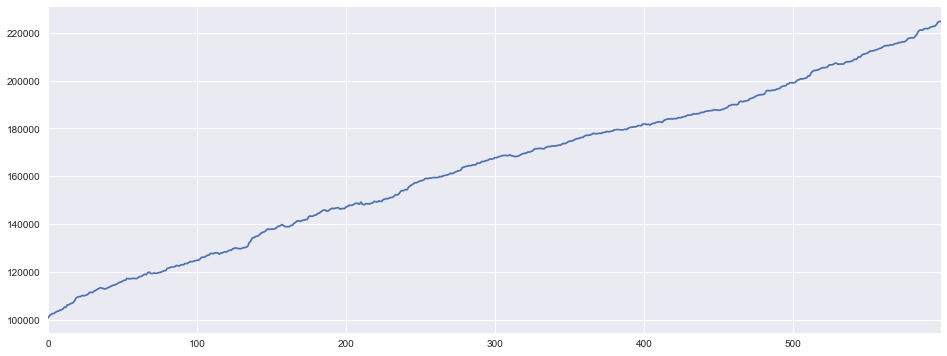

In [7]:
pd.Series(value_list).plot(figsize=(16,6))